In [0]:
!git clone https://github.com/jerzy456/Track_3

Cloning into 'Track_2'...
remote: Enumerating objects: 19669, done.
remote: Counting objects: 100% (19669/19669), done.
remote: Compressing objects: 100% (19669/19669), done.
remote: Total 19669 (delta 0), reused 19669 (delta 0), pack-reused 0
Receiving objects: 100% (19669/19669), 257.21 MiB | 15.92 MiB/s, done.
Checking out files: 100% (19672/19672), done.


In [0]:
!git clone https://github.com/rslim087a/track
!ls track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.


In [0]:
 !rm *.hdf5

In [0]:
ls

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, ConvLSTM2D, Conv3D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
from google.colab import files

In [0]:
datadir ='track'
columns = ['center', 'left','right', 'steering', 'throttle','reverse', 'speed']
data=pd.read_csv(os.path.join(datadir,'driving_log.csv'), names = columns, index_col=False )
pd.set_option('display.max_colwidth',-1)
data.head()

In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

In [0]:
data['center']=data['center'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)

In [0]:
data.head()

In [0]:
num_bins = 25
samples_per_bin = 400
hist, bins =np.histogram(data['steering'],num_bins)
center =(bins[:-1]+bins[1:])*0.5
print(bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [0]:
print('All data:', len(data))
remove_list =[]
for j in range(num_bins):
  list_ =[]
  for i in range(len(data['steering'])):
    if data['steering'][i]>=bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_= list_[samples_per_bin:]
  remove_list.extend(list_)
    
print('Removed:', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('Remaining:', len(data))



In [0]:

hist, bins =np.histogram(data['steering'],num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin, samples_per_bin))

***Loading pictures***


In [0]:
def load_img_steering(datadir,df):
  image_path=[]
  steering =[]
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[2], indexed_data[3]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings =np.asarray(steering)
  return image_paths, steerings

In [0]:
source = datadir +"/IMG"
image_paths, steerings = load_img_steering(source, data)

In [0]:
image_paths

In [0]:
x_train, x_valid, y_train, y_valid =train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

In [0]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')


axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

In [0]:
image = image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
fig,axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('original_image')

axes[1].imshow(zoom(original_image))
axes[1].set_title('preprocessed_image')

In [0]:
def pan(image):
  pan=iaa.Affine(translate_percent={"x":(-0.1,0.1), "y":(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

In [0]:
image = image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
fig,axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('original_image')

axes[1].imshow(pan(original_image))
axes[1].set_title('preprocessed_image')

In [0]:
def img_random_brightness(image):
  brightness_val=iaa.Multiply((0.2,1.2))
  image = brightness_val.augment_image(image)
  return image
  

In [0]:
image = image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
fig,axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('original_image')

axes[1].imshow(img_random_brightness(original_image))
axes[1].set_title('preprocessed_image')

In [0]:
def img_random_flip(image,steering_angle ):
  
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

In [0]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image=mpimg.imread(image)
flipped_image, flipped_steering_angle =img_random_flip(original_image,steering_angle)


fig,axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('original_image  '+ "angle:  " + str(steering_angle))

axes[1].imshow(flipped_image)
axes[1].set_title('preprocessed_image  '+ "angle:  " + str(flipped_steering_angle))

In [0]:
def random_augment(image,steering_angle):
  image = mpimg.imread(image)
  if np.random.rand()>0.5:
    image = pan(image)
  if np.random.rand()>0.5:
    image = zoom(image)
  if np.random.rand()>0.5:
    image = img_random_brightness(image)
  if np.random.rand()>0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle
    

In [0]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

*** Image processing***

In [0]:
def img_preprocess(img):
  
  img = img[60:135]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66))
  img=img/255
  return img
  

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

***Preprocessing data***

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  
        
      

X train shape:  (10, 66, 200, 3)
Y train shape:  (10,)


Text(0.5, 1.0, 'Validation Image')

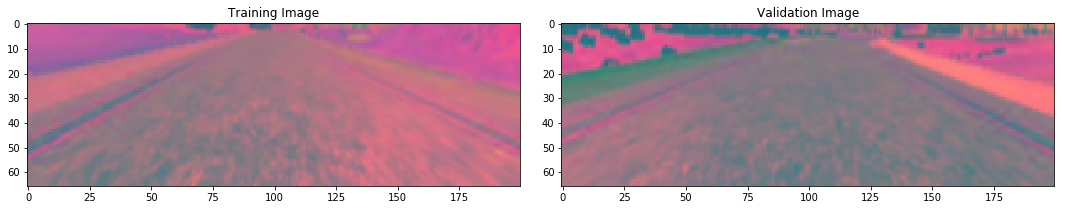

In [0]:
x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 10, 1))
x_valid_gen, y_valid_gen = next(batch_generator(x_valid, y_valid, 10, 0))

print("X train shape: ", x_train_gen.shape)
print("Y train shape: ", y_train_gen.shape)  
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

***Designing NVIDIA model***

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24,5,5,subsample=(2,2),input_shape =(66,200,3),activation='elu'))
  model.add(Convolution2D(36,5,5, subsample =(2,2),activation='elu'))
  model.add(Convolution2D(48,5,5, subsample =(2,2),activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  #model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  #model.add(Dropout(0.5))
  
  
  model.add(Dense(50,activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(10,activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(1,activation='tanh'))
  model.compile(loss='mse', optimizer = Adam(lr=1e-4))
  return model

In [0]:
def PilotNet_model():
  
  #Layers
  
  model = Sequential()
  model.add(Convolution2D(24,5,5,border_mode='valid',input_shape =(66,200,3), activation='elu', subsample=(2,2)))
  model.add(Dropout(0.1))
  model.add(Convolution2D(36,5,5,border_mode='valid', activation='elu', subsample=(2,2)))
  model.add(Dropout(0.2))
  model.add(Convolution2D(48,5,5,border_mode='valid', activation='elu', subsample=(2,2)))
  model.add(Dropout(0.2))
  model.add(Convolution2D(64,3,3,border_mode='valid', activation='elu', subsample=(1,1)))
  model.add(Dropout(0.2))
  model.add(Convolution2D(64,3,3,border_mode='valid', activation='elu', subsample=(1,1)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  
  model.add(Dense(1024, activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(500, activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='elu'))
  model.add(Dense(1, activation='tanh'))


  
  model.add(Dense(1))
  model.compile(loss='mse', optimizer = Adam(lr=1e-3))
  
  return model

In [0]:
#Callbacks
  filepath= 'PilotNet_model-{epoch:02d}-{val_loss:.2f}.hdf5'
  
  callback1 = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
  callback2 = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

In [0]:
model = nvidia_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               115300    
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [0]:
history = model.fit_generator(batch_generator(x_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=14,
                                  validation_data=batch_generator(x_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1,
                                  callbacks=[ callback1, callback2])

Instructions for updating:
Use tf.cast instead.
Epoch 1/14
300/300 [==============================] - 164s 546ms/step - loss: 0.0873 - val_loss: 0.0422
Epoch 2/14
300/300 [==============================] - 158s 526ms/step - loss: 0.0653 - val_loss: 0.0401
Epoch 3/14
300/300 [==============================] - 157s 522ms/step - loss: 0.0620 - val_loss: 0.0388
Epoch 4/14
300/300 [==============================] - 156s 521ms/step - loss: 0.0549 - val_loss: 0.0411


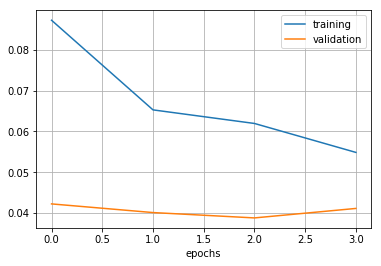

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.xlabel('epochs')
plt.grid(True)

In [0]:
#model.save('driving_model_12.hdf5')

In [0]:
#from google.colab import files

In [0]:
!ls

PilotNet_model-01-0.04.hdf5  PilotNet_model-03-0.04.hdf5  track
PilotNet_model-02-0.04.hdf5  sample_data		  Track_2


In [0]:
files.download('PilotNet_model-06-0.10.hdf5')

FileNotFoundError: ignored